In [10]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
import skimage.io
import matplotlib.pyplot as plt
from math import log10,sqrt

In [11]:
def CEDSmooth(image,size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return conv(image,g)

In [12]:
def conv_t(image):
  img_c=image.copy()
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      img_c[i][j]=image[image.shape[0]-1-i][image.shape[1]-j-1]
  return img_c

def conv(image,kernel):
  # kernel=conv_t(kernel)
  img_a=image.shape[0]
  img_b=image.shape[1]
  k_a=kernel.shape[0]
  k_b=kernel.shape[1]
  h=k_a//2
  w=k_b//2
  img_conv=np.zeros(image.shape)
  for i in range(h,img_a-h):
    for j in range(w,img_b-w):
      sum=0
      for m in range(k_a):
        for n in range(k_b):
          sum=sum+kernel[m][n]*image[i-h-k_a//2+m][j-w-k_b//2+n]
      img_conv[i][j]=sum
  return img_conv

In [13]:
def CEDGrads0(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = conv(img, Kx)
    Iy = conv(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 1
    return G
def CEDGrads1(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = conv(img, Kx)
    Iy = conv(img, Ky)
    theta = np.arctan2(Iy, Ix)
    
    return theta

In [14]:
def CEDNonMaxSup(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.float32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(0,M):
        for j in range(0,N):
            try:
                q = 255
                r = 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i][j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

In [15]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(0, M):
        for j in range(0, N):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [16]:
def CEDHysteris(img, lowThresholdRatio, highThresholdRatio):
    
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    plt.imshow(res, cmap = 'gray')
    return hysteresis(res, weak, strong)

In [17]:
def Canny(imga, lowThresholdRatio, highThresholdRatio):
    plt.figure(figsize = (15,15))

    plt.subplot(2,3,1)
    plt.title("Original")
    plt.imshow(imga, cmap = 'gray')

    imgb = CEDSmooth(imga,5,1.4)
    plt.subplot(2,3,2)
    plt.title("smoothed")
    plt.imshow(imgb, cmap = 'gray')

    img2=CEDGrads0(imgb)
    plt.subplot(2,3,3)
    plt.title("gradiant magnitudes")
    plt.imshow(img2, cmap = 'gray')

    imgc=CEDNonMaxSup(CEDGrads0(imgb),CEDGrads1(imgb))
    plt.subplot(2,3,4)
    plt.title("non max supress")
    plt.imshow(imgc, cmap = 'gray')
    
    plt.subplot(2,3,5)
    plt.title("double tresholding")
    imgd= CEDHysteris(imgc,0.07,0.11)
    plt.subplot(2,3,6)
    plt.title("edge tracking and final output")
    plt.imshow(imgd, cmap = 'gray')

    plt.show()

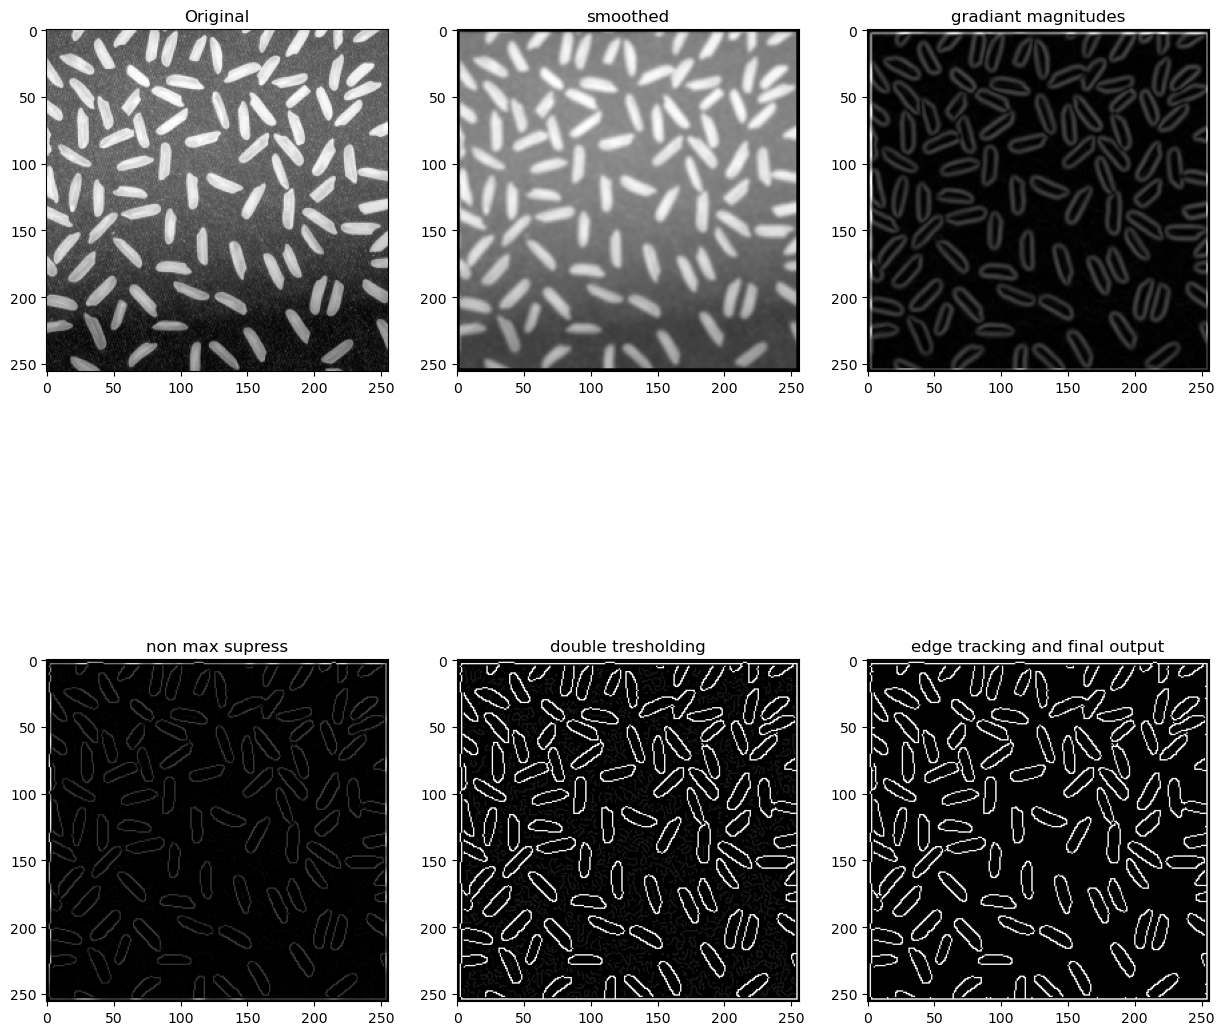

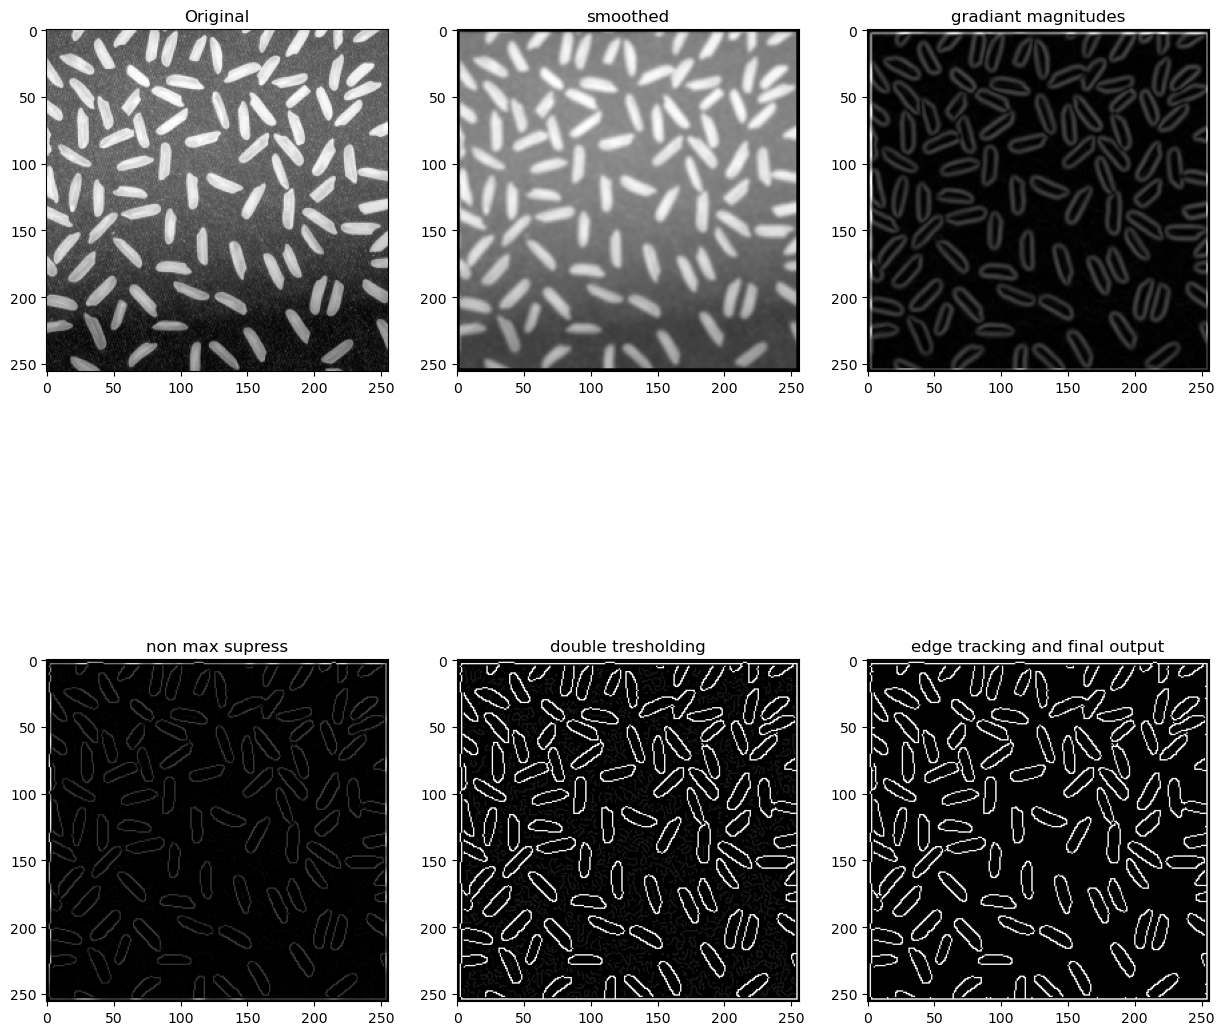

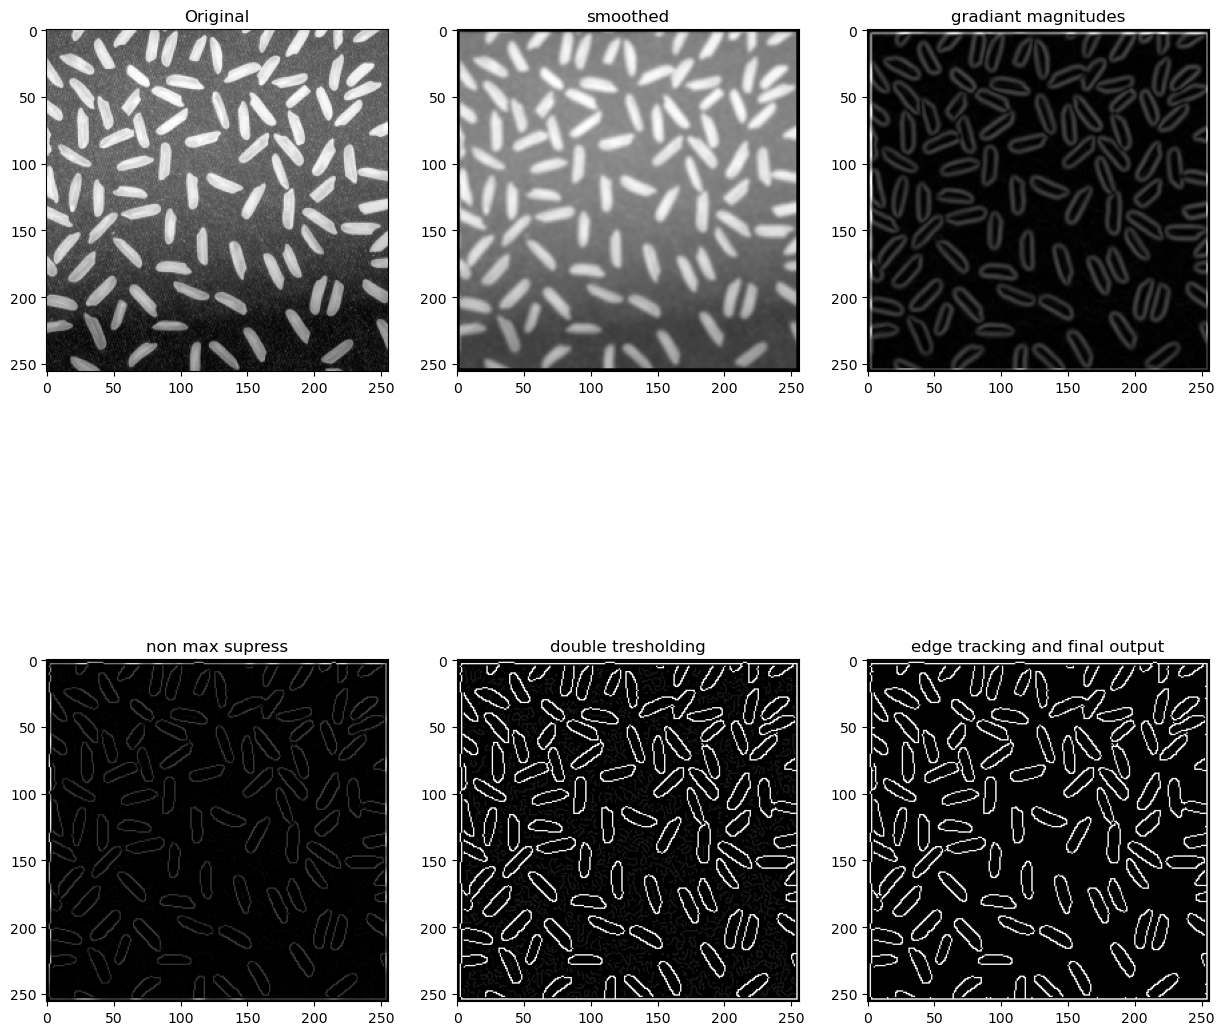

In [18]:
inputImg = image = skimage.io.imread("rice.png")
Canny(inputImg,0.07,0.11)
Canny(inputImg,0.05,0.14)
Canny(inputImg,0.09,0.1)

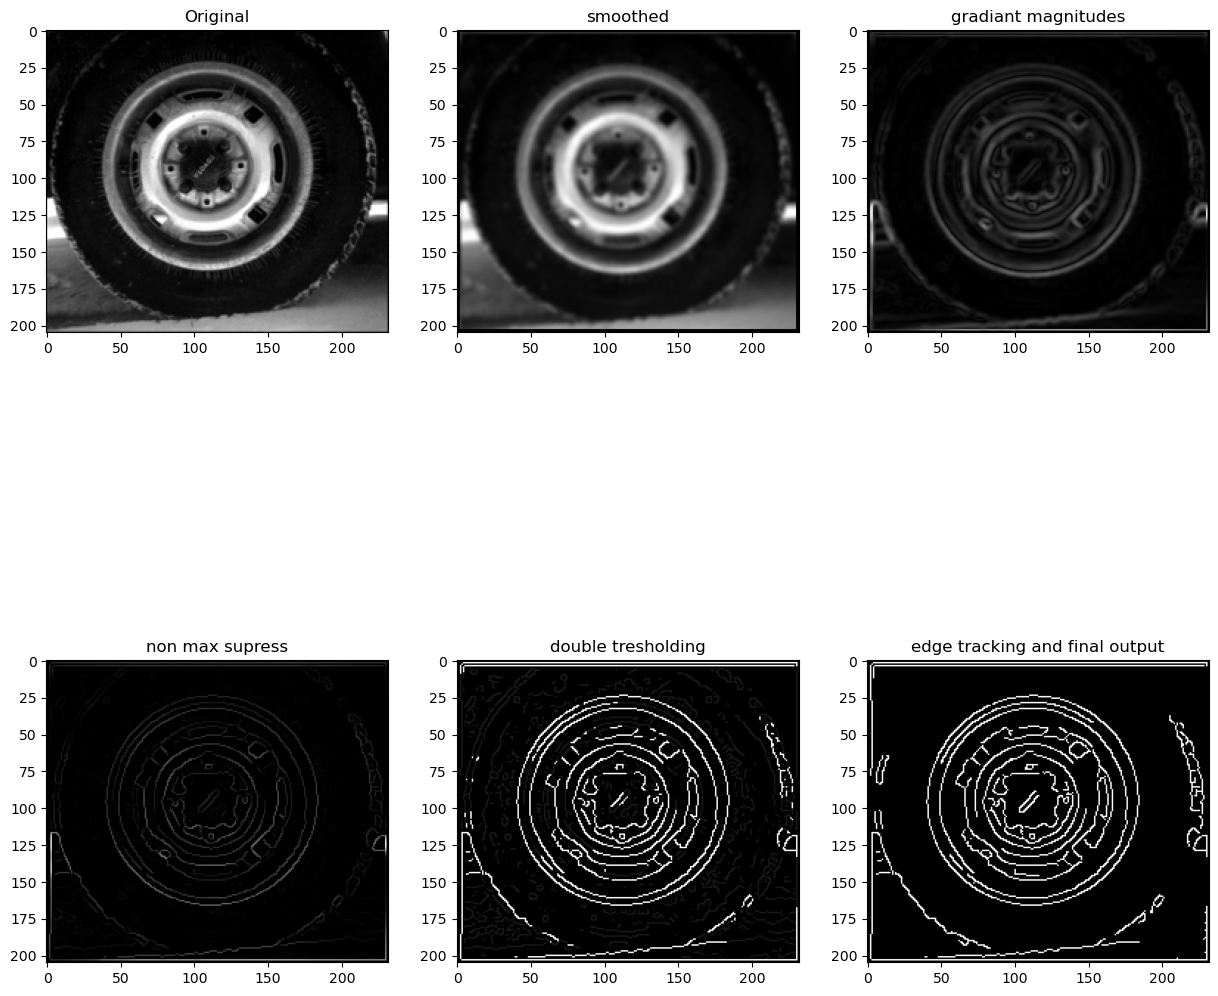

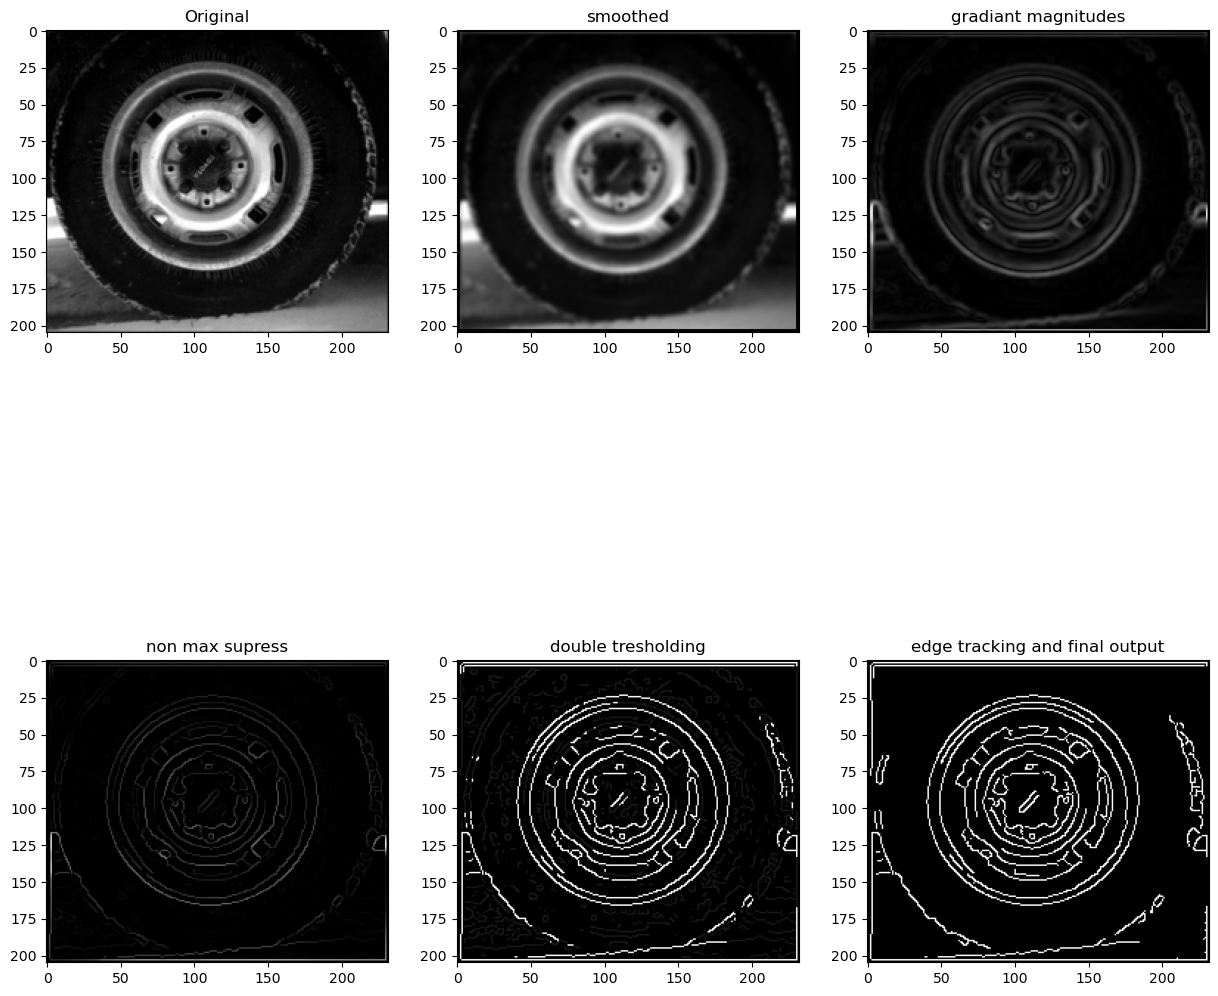

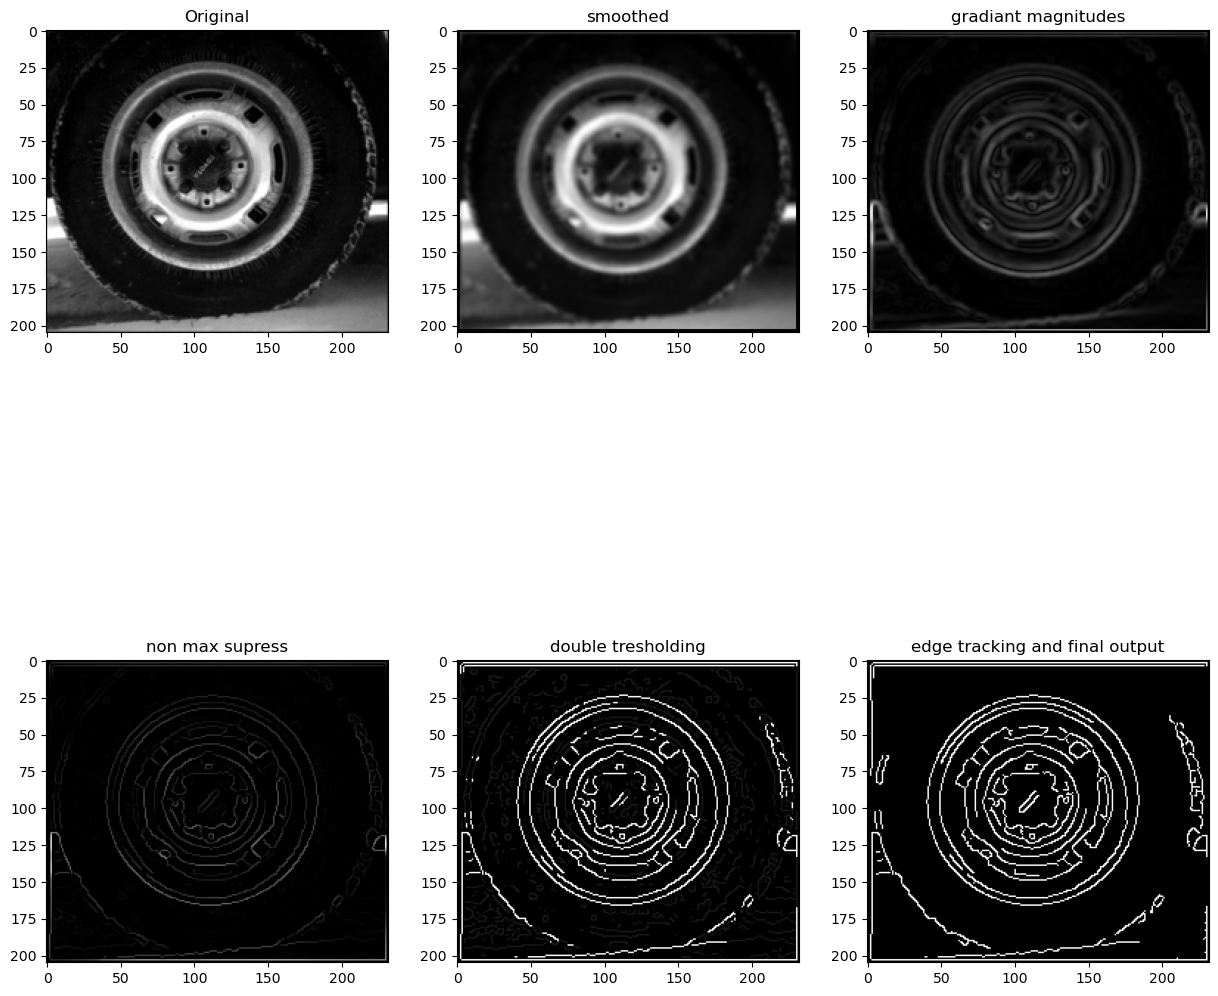

In [19]:
inputImg = image = skimage.io.imread("tire.tif")
Canny(inputImg,0.07,0.11)
Canny(inputImg,0.05,0.14)
Canny(inputImg,0.09,0.1)